In [311]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re

from tqdm import tqdm
import requests

from sklearn.feature_extraction.text  import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from scipy.sparse import hstack
from scipy import sparse

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

from collections import Counter

from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings(action='ignore')

In [255]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
submit_data = pd.read_csv("submit.csv")

test_data =  pd.merge(test_data,submit_data,on='id')




<h3> Cleaning Data </h3>

In [256]:
train_data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 186.5 MB


In [257]:
train_data.memory_usage(deep=True)

Index           128
id           166400
title       3491244
author      1438183
text      190283219
label        166400
dtype: int64

In [258]:
train_data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [259]:
train_data.columns

Index(['id', 'title', 'author', 'text', 'label'], dtype='object')

In [260]:
train_data.label.value_counts(normalize=True)

1    0.500625
0    0.499375
Name: label, dtype: float64

In [261]:
train_data['label'].value_counts()

1    10413
0    10387
Name: label, dtype: int64

In [262]:
train_data['title']

0        House Dem Aide: We Didn’t Even See Comey’s Let...
1        FLYNN: Hillary Clinton, Big Woman on Campus - ...
2                        Why the Truth Might Get You Fired
3        15 Civilians Killed In Single US Airstrike Hav...
4        Iranian woman jailed for fictional unpublished...
                               ...                        
20795    Rapper T.I.: Trump a ’Poster Child For White S...
20796    N.F.L. Playoffs: Schedule, Matchups and Odds -...
20797    Macy’s Is Said to Receive Takeover Approach by...
20798    NATO, Russia To Hold Parallel Exercises In Bal...
20799                            What Keeps the F-35 Alive
Name: title, Length: 20800, dtype: object

In [263]:
train_data['title'] = train_data['title'].astype("str")
train_data['text'] = train_data['text'].astype('str')

test_data['title'] = test_data['title'].astype("str")
test_data['text'] = test_data['text'].astype("str")

In [264]:
train_data['title'] = train_data['title'].str.lower()
train_data['text'] = train_data['text'].str.lower()

test_data['title'] = test_data['title'].str.lower()
test_data['text'] = test_data['text'].str.lower()

In [265]:
def decontracted(phrase):
    # specific
#     print(phrase)
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"didn\'t", "did not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    
    
    phrase = re.sub(r"won’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)
    phrase = re.sub(r"didn\’t", "did not", phrase)

    # general
    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)
    return phrase


def remove_special_char(phrase):
    phrase = re.sub('[^A-Za-z0-9]+', ' ', phrase)
    return phrase

def stemming(phrase):
    ps = PorterStemmer()
    words = word_tokenize(phrase)
    print(words)
    sent = []
    for w in words:
        sent.append(ps.stem(w))
    sent = ' '.join(sent)
    return sent

In [266]:
stemming("dances in the dance dance")

['dances', 'in', 'the', 'dance', 'dance']


'danc in the danc danc'

In [267]:
title_cleaned_tr = []
for title in train_data['title'].values:
#     print(type(title))
    title_clean = decontracted(title)
    title_cleaned_tr.append(title_clean)


title_cleaned_tr_sp = []

for title in title_cleaned_tr:
    title_clean = remove_special_char(title)
    title_cleaned_tr_sp.append(title_clean)




title_cleaned_tr_sm = []

for title in title_cleaned_tr_sp:
    title_clean = stemming(title)
    title_cleaned_tr_sm.append(title_clean)




['house', 'dem', 'aide', 'we', 'did', 'not', 'even', 'see', 'comey', 'is', 'letter', 'until', 'jason', 'chaffetz', 'tweeted', 'it']
['flynn', 'hillary', 'clinton', 'big', 'woman', 'on', 'campus', 'breitbart']
['why', 'the', 'truth', 'might', 'get', 'you', 'fired']
['15', 'civilians', 'killed', 'in', 'single', 'us', 'airstrike', 'have', 'been', 'identified']
['iranian', 'woman', 'jailed', 'for', 'fictional', 'unpublished', 'story', 'about', 'woman', 'stoned', 'to', 'death', 'for', 'adultery']
['jackie', 'mason', 'hollywood', 'would', 'love', 'trump', 'if', 'he', 'bombed', 'north', 'korea', 'over', 'lack', 'of', 'trans', 'bathrooms', 'exclusive', 'video', 'breitbart']
['life', 'life', 'of', 'luxury', 'elton', 'john', 'is', '6', 'favorite', 'shark', 'pictures', 'to', 'stare', 'at', 'during', 'long', 'transcontinental', 'flights']
['beno', 't', 'hamon', 'wins', 'french', 'socialist', 'party', 'is', 'presidential', 'nomination', 'the', 'new', 'york', 'times']
['excerpts', 'from', 'a', 'draf

[]
['police', 'fire', 'rubber', 'bullets', 'at', 'pipeline', 'protesters']
['ann', 'coulter', 'hits', 'supposed', 'gay', 'icon', 'kathy', 'griffin', 'on', 'isis', 'cribbed', 'antics']
['contaminated', 'food', 'from', 'china', 'now', 'entering', 'the', 'u', 's', 'under', 'the', 'organic', 'label']
['ten', 'famous', 'people', 'on', 'what', 'to', 'read', 'this', 'summer', 'the', 'new', 'york', 'times']
['scandal', 'epa', 'could', 'have', 'issued', 'an', 'emergency', 'order', '7', 'months', 'before']
['hillary', 'clinton', 'knew', '5', 'years', 'ago', 'anthony', 'weiner', 'was', 'a', 'pedophile', 'wikileaks']
['rt', 'arabic']
['a', '150', 'million', 'stairway', 'to', 'nowhere', 'on', 'the', 'far', 'west', 'side', 'the', 'new', 'york', 'times']
['cyber', 'war', 'from', 'trifle', 'to', 'catastrophe', 'information']
['president', 'putin', 'asks', 'us', 'to', 'stop', 'provoking', 'russia']
['inquiries', 'cloud', 'de', 'blasio', 'is', 'bid', 'to', 'come', 'off', 'as', 'strong', 'manager', 'befo

['sicher', 'trainieren', 'beim', 'spinning', 'gilt', 'ab', 'sofort', 'helmpflicht']
['every', 'asset', 'class', 'will', 'collapse', 'you', 'need', 'to', 'be', 'looking', 'at', 'your', 'wealth', 'in', 'terms', 'of', 'how', 'many', 'chickens', 'and', 'how', 'much', 'gas', 'you', 'can', 'buy']
['review', 'halt', 'and', 'catch', 'fire', 'time', 'travels', 'to', 'silicon', 'valley', 'is', 'dawn', 'the', 'new', 'york', 'times']
['obama', 'used', 'religious', 'test', 'to', 'favor', 'muslims', 'over', 'christians']
['wingsuit', 'flyer', 'vs', 'tree']
['nan']
['life', 'got', 'the', 'flu', 'here', 'is', '6', 'demands', 'you', 'can', 'extract', 'from', 'your', 'local', 'retirement', 'community', 'with', 'that', 'leverage']
['turkey', 'says', 'airport', 'bombers', 'were', 'from', 'kyrgyzstan', 'russia', 'and', 'uzbekistan', 'the', 'new', 'york', 'times']
['turmeric', 'is', 'more', 'powerful', 'than', '14', 'artificial', 'drugs']
['facebook', 'caught', 'selling', 'targeted', 'advertisement', 'which

['white', 'house', 'pushes', 'alternative', 'facts', 'here', 'are', 'the', 'real', 'ones', 'the', 'new', 'york', 'times']
['css', '10', '30', 'doug', 'hagmann', 'bob', 'griswold', 'mike', 'adams']
['nan']
['medical', 'study', 'shatters', 'the', 'theory', 'that', 'cannabis', 'acts', 'as', 'a', 'gateway', 'drug']
['review', 'the', 'americans', 'history', 'suddenly', 'feels', 'less', 'retro', 'the', 'new', 'york', 'times']
['klukowski', 'nuclear', 'option', 'restores', 'constitutional', 'balance']
['america', 'votes', 'against', 'empire']
['coffee', 'shop', 'customer', 'feels', 'good', 'about', 'leaving', 'a', '20', 'tip']
['world', 'war', '3', 'alert', 'u', 's', 'navy', 'is', 'new', '20', 'billion', 'weapon', 'will', 'dominate', 'the', 'south', 'china', 'sea']
['analyst', 'why', 'turkey', 'opening', 'border', 'to', 'millions', 'migrants', 'into', 'europe', 'is', 'a', 'good', 'thing']
['survey', 'shows', 'social', 'isolation', 'sexual', 'rejection', 'but', 'much', 'sympathy', 'for', 'tran

['turley', 'trump', 'making', 'same', 'arguments', 'as', 'obama', 'in', 'defense', 'of', 'immigration', 'executive', 'order', 'breitbart']
['from', 'bad', 'to', 'worse', 'obama', 'is', 'ransom', 'payment', 'to', 'iran', 'is', 'just', 'the', 'tip', 'of', 'the', 'iceberg']
['panic', 'across', 'country', 'for', 'a', 'day', 'after', 'govt', 'does', 'not', 'introduce', 'any', 'new', 'rule', 'on', 'demonetisation']
['video', 'this', 'will', 'change', 'the', 'way', 'you', 'watch', 'apocalypse', 'now']
['u', 'k', 'set', 'to', 'choose', 'sharp', 'break', 'from', 'european', 'union', 'the', 'new', 'york', 'times']
['georgia', 'abandons', 'ukraine', 'is', 'anti', 'russian', 'obsession', 'archil', 'sikharulidze']
['transgender', 'butchered', 'cut', 'to', 'pieces', 'liberal', 'media', 'silent', 'for', '1', 'reason']
['dear', 'milo', 'thank', 'you', 'breitbart']
['cher', 'just', 'destroyed', 'fake', 'republican', 'outrage', 'over', 'hillary', 'is', 'emails', 'with', 'one', 'tweet']
['blank', 'book',

['seven', 'world', 'historical', 'achievements', 'of', 'the', 'iraq', 'invasion', 'of', '2003']
['todd', 'trump', 'still', 'has', 'an', 'asterisk', 'breitbart']
['new', 'world', 'order', 'globalist', 'soros', 'is', 'the', 'hidden', 'hand', 'behind', 'trump', 'protests', 'and', 'riots']
['trump', 'pressures', 'obama', 'over', 'u', 'n', 'resolution', 'on', 'israeli', 'settlements', 'the', 'new', 'york', 'times']
['trump', 'will', 'win', 'but', 'is', 'he', 'the', 'real', 'deal']
['a', 'night', 'of', 'tornadoes', '3', 'are', 'dead', 'as', 'storms', 'sweep', 'the', 'midwest', 'the', 'new', 'york', 'times']
['anti', 'isis', 'coalition', 'too', 'busy', 'defeating', 'themselves', 'to', 'defeat', 'isis']
['rare', 'harmony', 'as', 'china', 'and', 'u', 's', 'commit', 'to', 'climate', 'deal', 'the', 'new', 'york', 'times']
['hillary', 'emails', 'taken', 'care', 'of']
['north', 'korea', 'threatens', 'israel', 'merciless', 'thousand', 'fold', 'punishment', 'breitbart']
['the', 'media', 'go', 'insane

['wwn', 'guide', 'to', 'blowing', 'your', 'hand', 'off', 'with', 'a', 'firework']
['clinton', 'campaign', 'says', 'fbi', 'has', 'double', 'standards', 'as', 'podesta', 'is', 'bestie', 'runs', 'the', 'new', 'doj', 'email', 'investigation']
['vp', 'mike', 'pence', 'tells', 'u', 's', 'naval', 'academy', 'grads', 'the', 'best', 'way', 'to', 'ensure', 'peace', 'breitbart']
['your', 'wednesday', 'briefing', 'donald', 'trump', 'hillary', 'clinton', 'iphone', 'the', 'new', 'york', 'times']
['exposed', 'stunning', 'cnn', 'super', 'damage', 'control', 'in', 'response', 'to', 'damning', 'videos', 'video']
['report', 'syrian', 'students', 'in', 'damascus', 'chant', 'death', 'to', 'america', 'death', 'to', 'israel']
['nanny', 'state', 'health', 'warning', 'burnt', 'toast', 'can', 'give', 'you', 'cancer', 'breitbart']
['hundreds', 'of', 'thousands', 'of', 'service', 'workers', 'planning', 'anti', 'trump', 'labor', 'strike']
['california', 'today', 'how', 'badly', 'do', 'you', 'want', 'that', 'new', 

['what', 'is', 'one', 'more', 'election', 'thread', 'ehhh']
['quake', 'exposes', 'italy', 'is', 'challenge', 'to', 'retrofit', 'its', 'architecture', 'the', 'new', 'york', 'times']
['israeli', 'minister', 'says', 'yahweh', 'did', 'earthquake', 'as', 'revenge']
['joss', 'whedon', 'fears', 'trump', 'administration', 'will', 'start', 'killing', 'gay', 'people']
['how', 'putin', 'derailed', 'the', 'west', 'is', 'grand', 'project', 'to', 'remake', 'the', 'world', 'mike', 'whitney']
['ukraine', 'fran', 'ois', 'fillon', 'quebec', 'your', 'wednesday', 'briefing', 'the', 'new', 'york', 'times']
['sanctuary', 'state', 'is', 'deported', 'alien', 'suspected', 'in', 'kidnapping', 'murder']
['podestaemails20', 'wikileaks', 'releases', 'another', 'batch', 'from', 'clinton', 'campaign', 'chair']
['nevertrump', 'radio', 'host', 'does', '180', 'makes', 'brilliant', 'case', 'for', 'voting', 'trump']
['federal', 'court', 'dismisses', 'claim', 'that', 'disney', 'violated', 'h1', 'b', 'visa', 'law']
['donal

['muckraking', 'marines', 'cards', 'and', 'cannabis', 'with', 'sheree', 'geo', 'truth', 'frequency', 'radio']
['cpac', 'straw', 'poll', 'finds', 'overwhelming', 'support', 'for', 'donald', 'trump', 'breitbart']
['6', 'natural', 'herbs', 'to', 'prevent', 'mental', 'disorders']
['brokaw', 'wouldemocrats', 'have', 'a', 'lot', 'of', 'reconstruction', 'to', 'do', 'of', 'their', 'own', 'party', 'breitbart']
['chrome', 'extension', 'blocks', 'united', 'flights', 'from', 'travel', 'search', 'results', 'breitbart']
['christians', 'celebrate', 'easter', 'breitbart']
['comment', 'on', 'democratic', 'party', 'operative', 'bob', 'beckel', 'calls', 'for', 'assassinating', 'wikileaks', 'julian', 'assange', 'by', 'truckjunkie']
['70', 'percent', 'approve', 'of', 'shinzo', 'abe', 'is', 'trump', 'visit', 'in', 'japan']
['germany', 'gleefully', 'leads', 'list', 'of', 'world', 'is', 'top', 'recyclers', 'the', 'new', 'york', 'times']
['swamps', 'marijuana', 'moonshine', '2', 'prison', 'escapees', '3', 'wee

['sweden', 'is', 'recycling', 'so', 'much', 'trash', 'it', 'is', 'running', 'out']
['64', 'percent', 'of', 'dea', 'fugitives', 'are', 'from', 'mexico', 'figures', 'show']
['baseball', 'is', 'practically', 'a', 'water', 'sport', 'to', 'the', 'mets', 'curtis', 'granderson', 'the', 'new', 'york', 'times']
['kathy', 'griffin', 'beheading', 'hollywood', 'is', 'feminist', 'a', 'list', 'cashes', 'in', 'on', 'global', 'suffering', 'of', 'people', 'of', 'color', 'breitbart']
['comment', 'on', 'this', 'is', 'the', 'man', 'militarized', 'police', 'at', 'standing', 'rock', 'are', 'working', 'for', 'by', 'hawkmo99']
['video', 'trump', 'explains', 'the', 'syrian', 'conflict', 'and', 'working', 'with', 'russia']
['syrian', 'war', 'report', 'october', '27', '2016', 'russian', 'strikes', 'destroyed', 'over', '300', 'terrorists', 'oil', 'facilities']
['she', 'was', 'no', 'bird', 'jane', 'eyre', 'manuscript', 'on', 'first', 'trip', 'to', 'america', 'the', 'new', 'york', 'times']
['catfished', 'by', 'a', 

[]
['newsthump', 'declared', 'an', 'enemy', 'of', 'the', 'people']
['chinese', 'companies', 'are', 'investing', 'american', 'manufacturing', 'plants']
['with', 'brazil', 'in', 'turmoil', 'rio', 'counts', 'down', 'to', 'olympics', 'the', 'new', 'york', 'times']
['obama', 'has', 'now', 'commuted', 'more', 'felons', 'sentences', 'than', 'previous', '11', 'presidents', 'combined']
['snapchat', 'finds', 'itself', 'on', 'the', 'wrong', 'side', 'of', 'a', 'racial', 'lens', 'again', 'the', 'new', 'york', 'times']
['bill', 'maher', 'invites', 'milo', 'yiannopoulos', 'and', 'another', 'guest', 'cancels', 'the', 'new', 'york', 'times']
['france', 'is', 'far', 'right', 'national', 'front', 'seeks', 'funding', 'from', 'united', 'arab', 'emirates']
['nan']
['russian', 'pianist', 'denis', 'matsuev', 'terrorized', 'in', 'us', 'for', 'supporting', 'putin']
['sean', 'spicer', 'trump', 'to', 'impose', 'up', 'to', 'five', 'executive', 'orders', 'on', 'day', 'one', 'breitbart']
['evangelicals', 'across', '

['like', 'magic', 'muggles', 'make', 'new', 'harry', 'potter', 'play', 'disappear', 'from', 'bookstores', 'the', 'new', 'york', 'times']
['report', 'shows', 'vast', 'reach', 'of', 'russian', 'doping', '1', '000', 'athletes', '30', 'sports', 'the', 'new', 'york', 'times']
['putin', 'confronts', 'the', 'new', 'world', 'order', 'valdai', 'video', 'part', '2', 'of', '2']
['14', 'days', 'to', 'do', '14', 'things', 'if', 'hillary', 'is', 'indicted', 'extreme', 'violence', 'expected']
['review', 'a', 'really', 'good', 'day', 'ayelet', 'waldman', 'is', 'better', 'living', 'through', 'lsd', 'the', 'new', 'york', 'times']
['russia', 'is', 'super', 'secret', 'spy', 'submarine', 'returns', 'to', 'sea', 'after', '16', 'years']
['facebook', 'working', 'on', 'brain', 'computer', 'interface', 'to', 'translate', 'thoughts', 'to', 'text', 'breitbart']
['one', 'treaty', 'could', 'change', 'the', 'fight', 'to', 'stop', 'the', 'dakota', 'access', 'pipeline']
['bill', 'o', 'areilly', 'thrives', 'at', 'fox',

['trump', 'agenda', 'on', 'offense', '7', 'stories', 'in', '24', 'hours', 'give', 'president', 'is', 'base', 'hope']
['what', 'happens', 'when', 'the', 'government', 'and', 'the', 'media', 'collude', 'to', 'pander', 'to', 'islam']
['iranians', 'arrested', 'after', 'celebrating', 'ancient', 'persian', 'king', 'cyrus', 'the', 'great']
['bernie', 'sanders', 'and', 'allies', 'aim', 'to', 'shape', 'democrats', 'agenda', 'after', 'primaries', 'the', 'new', 'york', 'times']
['jury', 'acquits', 'leaders', 'of', 'oregon', 'standoff', 'of', 'federal', 'charges']
['bombing', 'suspect', 'is', 'hometown', 'is', 'a', 'magnet', 'for', 'immigrants', 'the', 'new', 'york', 'times']
['pentagon', 'releases', 'photo', 'to', 'rebut', 'contention', 'it', 'bombed', 'a', 'mosque', 'the', 'new', 'york', 'times']
['supreme', 'court', 'vacates', 'ex', 'virginia', 'governor', 'is', 'graft', 'conviction', 'the', 'new', 'york', 'times']
['review', 'the', 'chainsmokers', 'find', 'that', 'pop', 'is', 'an', 'awkward', 

['chelsea', 'is', '3m', 'wedding', 'paid', 'by', 'foundation', 'emails', 'tax', 'free', 'funds', 'floated', 'a', 'decade', 'of', 'her', 'life']
['echo', 'chamber', 'senators', 'ask', 'jeff', 'sessions', 'same', 'question', 'about', 'russians', '12', 'times', 'breitbart']
['turnbull', 'to', 'propose', 'law', 'that', 'bans', 'boat', 'asylum', 'seekers', 'from', 'australia', 'permanently']
['nan']
['object', 'lessons', 'the', 'new', 'museum', 'explores', 'why', 'we', 'keep', 'things', 'the', 'new', 'york', 'times']
['update', 'on', 'hillary', 'clinton', 'is', 'crimes', 'and', 'misdemeanors', '2', 'videos', '10', 'mins']
['migrant', 'stabs', 'christian', 'woman', 'because', 'she', 'was', 'reading', 'bible']
['how', 'the', 'fda', 'manipulates', 'the', 'media']
['three', 'women', 'arrested', 'in', 'ongoing', 'counterterrorism', 'investigation']
['investigation', 'launched', 'after', 'texas', 'judge', 'wears', 'pussy', 'hat', 'in', 'courtroom', 'breitbart']
['gawker', 'is', 'new', 'owner', 'd

['france', 'is', 'macron', 'and', 'le', 'pen', 'to', 'face', 'off', 'in', 'crucial', 'pre', 'election', 'tv', 'debate']
['strong', 'job', 'gains', 'for', 'second', 'month', 'reframe', 'economic', 'outlook', 'the', 'new', 'york', 'times']
['the', 'vibration', 'of', 'the', 'world']
['police', 'ohio', 'woman', 'raped', 'four', 'year', 'old']
['the', 'chronovisor', 'a', 'device', 'used', 'to', 'look', 'into', 'the', 'future', 'and', 'past']
['espn', 'makes', 'sudden', 'guidelines', 'change', 'to', 'limit', 'on', 'air', 'talent', 'is', 'political', 'commentary', 'breitbart']
['a', 'rabbi', 'is', 'enduring', 'sermon', 'on', 'living', 'your', 'last', 'five', 'minutes', 'the', 'new', 'york', 'times']
['syrian', 'mother', 'isis', 'baked', 'christians', 'adults', 'kneaded', 'christian', 'children', 'in', 'bakery', 'machines']
['report', 'hillary', 'clinton', 'spent', 'notens', 'of', 'millions', 'of', 'dollars', 'on', 'failed', 'digital', 'youth', 'outreach', 'campaign', 'breitbart']
['the', 'ver

['nan']
['poultry', 'has', 'a', 'pedigree', 'at', 'le', 'coq', 'rico', 'the', 'new', 'york', 'times']
['want', 'to', 'dispute', 'media', 'polling']
['sen', 'grassley', 'gorsuch', 'confirmation', 'ends', 'schumer', 'is', '16', 'year', 'era', 'of', 'filibustering', 'judges']
['the', 'orthodox', 'nationalist', 'albania', 'is', 'alliance', 'with', 'globalism']
['hillary', 'is', '70', 'days', 'away', 'from', 'controlling', 'all', 'food', 'and', 'water']
['nan']
['a', 'digital', '9', '11', 'if', 'trump', 'wins']
['11', 'great', 'reads', 'that', 'have', 'nothing', 'to', 'do', 'with', 'politics', 'the', 'new', 'york', 'times']
['review', 'powerless', 'on', 'nbc', 'has', 'cubicles', 'not', 'capes', 'the', 'new', 'york', 'times']
['lawyers', 'mobilize', 'at', 'nation', 'is', 'airports', 'after', 'trump', 'is', 'order', 'the', 'new', 'york', 'times']
['comment', 'on', 'america', 'is', 'now', 'at', 'its', 'greatest', 'risk', 'of', 'a', 'false', 'flag', 'attack', 'by', 'toby']
['aider', 'les', 'mig

['nyt', 'fbi', 'failed', 'to', 'connect', 'trump', 'to', 'putin']
['nothey', 'live', 'possibly', 'the', 'most', 'powerful', 'message', 'in', 'a', 'movie']
['a', 'wizard', 'comes', 'to', 'the', 'stage', 'harry', 'potter', 'and', 'the', 'cursed', 'child', 'begins', 'previews', 'in', 'london', 'the', 'new', 'york', 'times']
['gems', 'hidden', 'in', 'plain', 'sight', 'in', 'macedonia', 'the', 'new', 'york', 'times']
['american', 'irrationalism']
['london', 'bridge', 'terror', 'ringleader', 'may', 'have', 'plotted', 'to', 'attack', 'wimbledon']
['podesta', 'brothers', 'kidnapped', 'a', '3yo', 'british', 'girl', 'in', 'portugal', 'wikileaks']
['thai', 'officials', 'battle', 'buddhist', 'monks', 'over', 'tigers', 'fate', 'the', 'new', 'york', 'times']
['bombing', 'suspect', 'pleads', 'not', 'guilty', 'in', 'shootout', 'with', 'new', 'jersey', 'officers', 'the', 'new', 'york', 'times']
['regards', 'chang', 's', 'et', 'langues', 'd', 'li', 'es', 'des', 'musulmanes', 'voquent', 'l', 'europe', 'd

['hillaryous', 'huckabee', 'compares', 'clintons', 'to', 'these', 'famous', 'mobsters']
['afrofuturism', 'the', 'next', 'generation', 'the', 'new', 'york', 'times']
['pro', 'brexit', 'city', 'of', 'sunderland', 'glad', 'to', 'poke', 'establishment', 'in', 'the', 'eye', 'the', 'new', 'york', 'times']
['his', 'predecessor', 'gone', 'gambia', 'is', 'new', 'president', 'finally', 'comes', 'home', 'the', 'new', 'york', 'times']
['bill', 'gross', 'and', 'pimco', 'settle', 'suit', 'over', 'his', 'ouster', 'the', 'new', 'york', 'times']
['europe', 'has', 'no', 'future', 'putin', 'slams', 'austria', 'migrant', 'child', 'rape', 'injustice']
['interview', 'why', 'did', 'quito', 'cut', 'assange', 'is', 'access', 'to', 'the', 'internet']
['re', 'the', 'election', 'of', 'donald', 'trump', 'is', 'already', 'having', 'an', 'enormous', 'impact', 'on', 'the', 'economy']
['pointless', 'winner', 'will', 'not', 'let', '500', 'prize', 'change', 'his', 'life']
['dr', 'david', 'duke', 'farren', 'shoaf', 'coun

['welcome', 'to', 'paris', 'where', 'tour', 'buses', 'have', 'to', 'navigate', 'around', 'all', 'the', 'new', 'muslim', 'tent', 'cities', 'filling', 'the', 'streets']
['holy', 'voter', 'fraud', 'reverends', 'caught', 'on', 'cam', 'we', 'tell', 'them', 'who', 'to', 'vote', 'for']
['breaking', 'syrian', 'air', 'force', 'strikes', 'turkish', 'forces']
['first', 'ever', 'footage', 'of', 'aging', 'tar', 'sands', 'pipelines', 'beneath', 'great', 'lakes']
['krauthammer', 'childish', 'pathetic', 'hillary', 'will', 'not', 'take', 'blame', 'for', 'election', 'loss', 'breitbart']
['ivanka', 'trump', 'to', 'head', 'review', 'of', 'u', 's', 'role', 'in', 'paris', 'climate', 'change', 'agreement', 'breitbart']
['us', 'backed', 'saudi', 'airstrikes', 'kill', '100', 'yemenis', 'in', 'two', 'days']
['villager', 'is', 'execution', 'in', 'china', 'ignites', 'uproar', 'over', 'inequality', 'of', 'justice', 'the', 'new', 'york', 'times']
['still', 'not', 'thanking', 'native', 'americans']
['netanyahu', 'on

['democrats', 'are', 'going', 'back', 'into', 'florida', 'with', 'millions', 'of', 'dollars', 'to', 'retire', 'marco', 'rubio']
['why', 'you', 'should', 'pay', 'attention', 'to', 'the', 'anti', 'trump', 'riots', 'and', 'how', 'to', 'prepare']
['netflix', 'releases', 'teaser', 'for', 'wouldear', 'white', 'people', 'tv', 'series']
['u', 's', 'warns', 'north', 'carolina', 'that', 'transgender', 'bill', 'violates', 'civil', 'rights', 'laws', 'the', 'new', 'york', 'times']
['wh', 'press', 'secretary', 'sean', 'spicer', 'blasts', 'media', 'is', 'wouldeliberately', 'false', 'reporting', 'breitbart']
['jpmorgan', 'pays', '264', 'million', 'fine', 'for', 'bribing', 'chinese', 'officials']
['aleppo', 'donald', 'trump', 'istanbul', 'your', 'morning', 'briefing', 'the', 'new', 'york', 'times']
['this', 'comment', 'about', 'trump', 'is', 'win', 'will', 'make', 'you', 'think', 'hard', 'about', 'the', 'full', 'horror', 'of', 'what', 'just', 'happened']
['l', 'a', 'resist', 'rally', 'will', 'replace',

['nbc', 'news', 'releases', 'first', 'promo', 'for', 'isunday', 'night', 'with', 'megyn', 'kelly', 'video']
['steve', 'pieczenik', 'wikileaks', 'revelations', 'a', 'counter', 'coup', 'to', 'america', 'is', 'takeover', 'video']
['at', 'penn', 'station', 'rail', 'mishap', 'spurs', 'large', 'and', 'lasting', 'headache', 'the', 'new', 'york', 'times']
['falluja', 'restaurant', 'is', 'reborn', 'in', 'baghdad', 'offering', 'nostalgia', 'with', 'its', 'kebab', 'the', 'new', 'york', 'times']
['penn', 'station', 'inhabitant', 'finally', 'has', 'a', 'home', 'of', 'her', 'own', 'the', 'new', 'york', 'times']
['graham', 'hancock', 'explains', 'why', 'so', 'many', 'people', 'are', 'pro', 'trump', 'and', 'anti', 'establishment']
['it', 'is', 'not', 'easy', 'being', 'santa', 'the', 'new', 'york', 'times']
['college', 'student', 'who', 'accused', 'football', 'players', 'with', 'rape', 'now', 'charged', 'with', 'lying']
['gary', 'johnson', 'and', 'jill', 'stein', 'fail', 'to', 'make', 'cut', 'for', 'fi

['on', '9', '11', 'anniversary', 'somber', 'reflections', 'on', 'lives', 'and', 'a', 'world', 'changed', 'the', 'new', 'york', 'times']
['veterans', 'back', 'on', 'patrol', 'this', 'time', 'to', 'protect', 'marijuana', 'the', 'new', 'york', 'times']
['basketball', 'player', 'suffers', 'gruesome', 'injury', 'when', 'eyeball', 'is', 'popped', 'out', 'during', 'game', 'breitbart']
['russians', 'no', 'longer', 'dispute', 'olympic', 'doping', 'operation', 'the', 'new', 'york', 'times']
['ositran', 'pcm', 'le', 'baja', 'el', 'dedo', 'a', 'benavente', 'por', 'herbert', 'mujica', 'rojas']
['wintry', 'blast', 'in', 'greece', 'imperils', 'refugees', 'in', 'crowded', 'camps', 'the', 'new', 'york', 'times']
['surviving', 'off', 'grid', '5', 'ways', 'to', 'manage', 'chimney', 'creosote']
['exposed', 'billionaire', 'globalist', 'soros', 'behind', 'trump', 'protests', 'provoking', 'us', 'color', 'revolution']
['russia', 'has', 'deployed', 'missile', 'barred', 'by', 'treaty', 'u', 's', 'general', 'tel

['in', 'sight', 'yet', 'elusive', 'the', 'new', 'york', 'times']
['boom', 'canada', 'and', 'mexico', 'cave', 'ahead', 'of', 'trump', 'presidency', 'they', 'are', 'ready', 'to', 'renegotiate', 'nafta', 'trade', 'deal']
['british', 'police', 'making', 'terror', 'arrests', 'on', 'near', 'daily', 'basis']
['cal', 'poly', 'state', 'president', 'defends', 'milo', 'is', 'right', 'to', 'speak', 'on', 'campus', 'breitbart']
['santa', 'monica', 'cuts', 'ties', 'with', 'wells', 'fargo', 'over', 'pipeline', 'breitbart']
['on', 'same', 'day', 'obama', 'throws', 'top', 'us', 'marine', 'general', 'in', 'jail', 'then', 'allows', 'isis', 'leader', 'to', 'escape']
['how', 'to', 'have', 'a', 'true', 'democracy', 'video']
['is', 'brexit', 'never', 'gon', 'na', 'happen', 'leaked', 'audio', 'recording', 'reveals', 'theresa', 'may', 'is', 'notrue', 'fears', 'about', 'brexit']
['highway', 'horror', 'mexican', 'cartel', 'kidnap', 'murder', 'beer', 'delivery', 'men']
['where', 'to', 'be', 'single', 'in', 'new',

['what', 'are', 'the', 'ukronazis', 'up', 'to', 'in', 'crimea', 'russia', 'news', 'now']
['fs1', 'is', 'sharpe', 'black', 'nfl', 'coaches', 'not', 'held', 'to', 'same', 'standard', 'as', 'white', 'counterparts', 'breitbart']
['highlights', 'of', 'donald', 'trump', 'is', 'immigration', 'speech', 'and', 'mexico', 'trip', 'the', 'new', 'york', 'times']
['u', 's', 'nuclear', 'weapons', 'tests', 'come', 'to', 'youtube', 'the', 'new', 'york', 'times']
['u', 'n', 'ambassador', 'nikki', 'haley', 'u', 's', 'not', 'ruling', 'anything', 'out', 'in', 'response', 'to', 'north', 'korea']
['geoengineering', 'watch', 'global', 'alert', 'news', 'november', '12', '2016', 'geoengineering', 'watch', 'global', 'alert', 'news', 'november', '12', '2016', 'geoengineering', 'watch']
['how', 'donald', 'trump', 'moving', 'the', 'u', 's', 'embassy', 'from', 'tel', 'aviv', 'to', 'jerusalem', 'could', 'trigger', 'the', 'psalm', '83', 'war']
['sheriff', 'giving', 'sex', 'offenders', 'to', 'ice', 'damages', 'communit

['putin', 'just', 'exposed', 'us', 'election', 'rigging', 'by', 'trolling', 'the', 'state', 'dept', 'in', 'the', 'most', 'hilarious', 'way']
['nan']
['breaking', 'judge', 'issues', 'restraining', 'order', 'against', 'donald', 'trump']
['trump', 'is', 'choice', 'on', 'obamacare', 'sabotage', 'or', 'co', 'opt', 'the', 'new', 'york', 'times']
['8', 'reasons', 'why', 'you', 'should', 'try', 'photography', 'as', 'a', 'hobby']
[]
['the', 'left', 'is', 'funny']
['fear', 'and', 'loathing', 'inside', 'the', 'deep', 'state']
['anonymous', 'hacker', 'fighting', 'for', 'justina', 'pelletier', 'pleads', 'not', 'guilty', 'in', 'children', 'is', 'hospital', 'ddos', 'attack']
['terry', 'branstad', 'iowa', 'governor', 'is', 'trump', 'is', 'pick', 'as', 'china', 'ambassador', 'the', 'new', 'york', 'times']
['how', 'does', 'populism', 'turn', 'authoritarian', 'venezuela', 'is', 'a', 'case', 'in', 'point', 'the', 'new', 'york', 'times']
['amid', 'rain', 'of', 'shells', 'aleppo', 'is', 'civilians', 'offer'

['donald', 'trump', 'is', 'speech', 'what', 'you', 'missed', 'and', 'our', 'fact', 'checks', 'the', 'new', 'york', 'times']
['phil', 'collins', 'is', 'very', 'much', 'alive', 'the', 'new', 'york', 'times']
['israel', 'a', 'medical', 'marijuana', 'pioneer', 'is', 'eager', 'to', 'capitalize', 'the', 'new', 'york', 'times']
['trump', 'snapchat', 'mosul', 'your', 'wednesday', 'evening', 'briefing', 'the', 'new', 'york', 'times']
['north', 'korean', 'defector', 'says', 'kim', 'jong', 'un', 'is', 'control', 'is', 'crumbling', 'the', 'new', 'york', 'times']
['in', 'washington', 'pizzeria', 'attack', 'fake', 'news', 'brought', 'real', 'guns', 'the', 'new', 'york', 'times']
['telling', 'sign', 'many', 'supporters', 'of', 'brexit', 'expect', 'defeat', 'the', 'new', 'york', 'times']
['an', 'olympic', 'event', 'where', '1st', 'prize', 'is', 'the', 'chance', 'to', 'lose', 'billions', 'the', 'new', 'york', 'times']
[]
['beyond', 'hidden', 'figures', 'nurturing', 'new', 'black', 'and', 'latino', 'mat

['i', 'am', 'running', 'out', 'of', 'popcorn', 'harvey', 'organ']
['california', 'democrats', 'propose', 'in', 'state', 'tuition', 'for', 'refugees', 'breitbart']
['trump', 'favors', 'ending', 'obamacare', 'subsidies', 'breitbart']
['now', 'more', 'than', 'ever', 'we', 'must', 'tell', 'the', 'truth', 'about', 'the', 'iraq', 'war']
['uber', 'partners', 'with', 'daimler', 'in', 'a', 'step', 'toward', 'a', 'driverless', 'future', 'the', 'new', 'york', 'times']
['fear', 'of', 'donald', 'trump', 'helps', 'democrats', 'mobilize', 'hispanics', 'the', 'new', 'york', 'times']
['c', 'span', 'delivers', 'on', 'sit', 'in', 'even', 'with', 'cameras', 'off', 'the', 'new', 'york', 'times']
['donald', 'trump', 'repeatedly', 'warned', 'anthony', 'weiner', 'was', 'a', 'national', 'security', 'risk']
['mark', 'blyth', 'and', 'wendy', 'schiller', 'election', '2016', 'what', 'happened', 'and', 'why']
['grammys', 'to', 'feature', 'first', 'man', 'transgender', 'woman', 'as', 'notrophy', 'girls']
['vereinigt

['video', 'fight', 'breaks', 'out', 'on', 'southwest', 'airlines', 'as', 'it', 'lands', 'at', 'burbank', 'airport']
['vladimir', 'putin', 'straight', 'from', 'the', 'horse', 'is', 'mouth']
['touring', 'warship', 'trump', 'pushes', 'plan', 'to', 'expand', 'military', 'the', 'new', 'york', 'times']
['national', 'security', 'agency', 'said', 'to', 'use', 'manhattan', 'tower', 'as', 'listening', 'post', 'the', 'new', 'york', 'times']
['watchdog', 'claims', '5k', 'noncitizens', 'registered', 'to', 'vote', 'in', 'virginia']
['a', 'song', 'for', 'bill', 'de', 'blasio', 'sounds', 'a', 'sour', 'note', 'for', 'watchdogs', 'the', 'new', 'york', 'times']
['dyson', 'wants', 'to', 'create', 'a', 'hair', 'dryer', 'revolution', 'the', 'new', 'york', 'times']
['delingpole', 'mass', 'murdering', 'bureaucrat', 'tells', 'trump', 'how', 'to', 'run', 'epa']
['wait', 'a', 'minute', 'is', 'early', 'voting', 'part', 'of', 'campaigning']
['when', 'it', 'comes', 'to', 'fake', 'news', 'the', 'us', 'government', '

['trump', 'is', 'moronic', 'supporters', 'in', 'the', 'militias', 'armed', 'and', 'ready', 'if', 'clinton', 'wins']
['4', 'trailers', 'that', 'have', 'us', 'excited', 'for', '2017', 'the', 'new', 'york', 'times']
['us', 'secretly', 'using', 'tunisia', 'airbase', 'for', 'drones', 'spying', 'on', 'libya', 'sources']
['police', 'discover', 'man', 'is', 'severed', 'head', 'on', 'home', 'is', 'front', 'porch', 'breitbart']
['dennis', 'kucinich', 'channels', 'smedley', 'darlington', 'butler']
['pope', 'tells', 'marchers', 'protect', 'life', 'from', 'the', 'moment', 'of', 'conception']
['chelsea', 'handler', 'calls', 'trump', 'a', 'f', 'cking', 'loser', 'at', 'l', 'a', 'library', 'benefit']
['breitbart', 'news', 'daily', 'the', 'final', 'week', 'breitbart']
['is', 'halloween', 'evil', 'why', 'witches', 'occultists', 'and', 'satanists', 'celebrate', 'halloween', 'and', 'why', 'you', 'should', 'not']
['young', 'patient']
['iraqi', 'christians', 'raise', 'giant', 'cross', 'on', 'land', 'liberate

['nan']
['will', 'el', 'chapo', 'risk', 'trial', 'can', 'he', 'afford', 'not', 'to', 'the', 'new', 'york', 'times']
['forgotten', 'no', 'longer', 'pennsylvania', 'breitbart', 'readers', 'praise', 'trump', 'paris', 'decision']
['political', 'coup', 'underway', 'in', 'venezuela']
['nan']
['truth', 'about', 'mosul', 'to', 'emerge', 'at', 'mass', 'funerals']
['simple', 'rules', 'for', 'healthy', 'eating', 'the', 'new', 'york', 'times']
['nan']
['trump', 'raises', '13', '2', 'million', 'for', '2020', 're', 'election', 'campaign', 'in', 'first', 'quarter']
['obamas', 'dine', 'with', 'bono', 'in', 'nyc', 'receive', 'standing', 'ovation']
['media', 'spin', 'the', 'fbi', 'is', 'actions', 'are', 'deeply', 'troubling', 'not', 'hillary', 'is']
['america', 'is', 'streets', 'will', 'run', 'red', 'with', 'blood', 'mike', 'adams']
['hillary', 'clinton', 'assails', 'james', 'comey', 'calling', 'email', 'decision', 'deeply', 'troubling', 'the', 'new', 'york', 'times']
['police', 'hope', 'lgbt', 'police'

['damning', 'clinton', 'footage', 'leaks', 'days', 'before', 'election', 'see', 'it', 'before', 'it', 'is', 'deleted']
['review', 'hairspray', 'live', 'had', 'power', 'voices', 'but', 'still', 'lacked', 'power', 'the', 'new', 'york', 'times']
['eating', 'a', 'vagina', 'cures', 'cancer', 'according', 'to', 'cancer', 'treatment', 'studies']
['the', 'u', 's', 'revolution', 'is', 'underway', 'hillary', 'clinton', 'is', 'coup', 'has', 'been', 'stopped']
['clinton', 'campaign', 'urges', 'fbi', 'to', 'detail', 'new', 'developments', 'in', 'email', 'case']
['europe', 'mounts', 'historic', 'challenge', 'to', 'google', 'is', 'domination', 'of', 'tech', 'services']
['house', 'may', 'have', 'to', 'vote', 'again', 'on', 'american', 'health', 'care', 'act', 'breitbart']
['afghanistan', 'is', 'green', 'gold', 'taliban', 'terrorists', 'earn', '15', 'million', 'a', 'year', 'selling', 'pistachios']
['donald', 'trump', 'attacks', 'isleepy', 'eyes', 'chuck', 'todd', 'for', 'phony', 'russia', 'story']
['go

['protesters', 'disturb', 'ryan', 'lochte', 'is', 'debut', 'on', 'dancing', 'with', 'the', 'stars', 'the', 'new', 'york', 'times']
['donald', 'trump', 'landslide', 'victory', 'becomes', '45th', 'us', 'president']
['anonymous', 'hacker', 'deric', 'lostutter', 'faces', '16', 'years', 'in', 'prison', 'while', 'steubenville', 'rapists', 'walk', 'free']
['with', 'degree', 'debunked', 'melania', 'trump', 'website', 'is', 'taken', 'down', 'the', 'new', 'york', 'times']
['is', 'hayden', 'a', 'boy', 'or', 'girl', 'both', 'post', 'gender', 'baby', 'names', 'are', 'on', 'the', 'rise', 'the', 'new', 'york', 'times']
['abc', 'casts', 'first', 'black', 'bachelorette', 'rachel', 'lindsay', 'a', 'texas', 'lawyer', 'the', 'new', 'york', 'times']
['nan']
['is', 'this', 'why', 'the', 'smash', 'in', 'gold', 'silver', 'is', 'happening', 'a', 'shocking', 'game', 'changer', 'for', 'gold', 'silver', 'is', 'now', 'unfolding']
['beginning', 'a', 'new', 'life', 'in', 'america', 'with', 'mentors', 'by', 'their', 

['john', 'legend', 'hopefully', 'trump', 'will', 'not', 'last', 'the', 'next', 'four', 'years']
['this', 'is', 'what', 'constipation', 'does', 'to', 'your', 'body']
['todd', 'kohlhepp', 'confesses', 'to', 'superbike', 'motorsports', 'homicides', 'guardian', 'liberty', 'voice']
['a', 'trump', 'fan', 'just', 'put', 'hillary', 'in', 'an', 'electric', 'chair', 'on', 'his', 'front', 'lawn']
['alex', 'rodriguez', 'is', 'at', 'peace', 'as', 'he', 'walks', 'away', 'the', 'new', 'york', 'times']
['unrelenting', 'assault', 'on', 'aleppo', 'is', 'called', 'worst', 'yet', 'in', 'syria', 'is', 'civil', 'war', 'the', 'new', 'york', 'times']
['trump', 'voter', 'is', 'insane', 'reason', 'for', 'voting', 'for', 'trump', 'is', 'making', 'internet', 'lose', 'it', 'tweets']
['camera', 'catches', 'woman', 'is', 'spirit', 'leaving', 'body', 'after', 'car', 'accident']
['minnesota', 'players', 'rescind', 'boycott', 'and', 'will', 'play', 'in', 'holiday', 'bowl', 'the', 'new', 'york', 'times']
['rules', 'of',

['manslaughter', 'charge', 'for', 'tulsa', 'officer', 'who', 'killed', 'black', 'driver', 'the', 'new', 'york', 'times']
['lawsuit', 'aims', 'to', 'hold', '2', 'contractors', 'accountable', 'for', 'c', 'i', 'a', 'torture', 'the', 'new', 'york', 'times']
['how', 'to', 'survive', 'a', 'nuclear', 'fallout']
['timber', 'company', 'tells', 'california', 'town', 'go', 'find', 'your', 'own', 'water', 'the', 'new', 'york', 'times']
['after', 'shake', 'up', 'by', 'trump', 'clinton', 'camp', 'keeps', 'wary', 'eye', 'on', 'conspiracy', 'theories', 'the', 'new', 'york', 'times']
['video', 'sheriff', 'clarke', 'and', 'judge', 'jeanine', 'make', 'their', 'final', 'election', 'day', 'prediction', 'truthfeed']
['ichiro', 'suzuki', 'reaches', '3', '000', 'hits', 'again', 'breaking', 'ground', 'for', 'japanese', 'players', 'the', 'new', 'york', 'times']
['brexit', 'talks', 'will', 'start', 'by', 'end', 'of', 'march', 'theresa', 'may', 'says', 'the', 'new', 'york', 'times']
['isabelle', 'huppert', 'the',

['easy', 'natural', 'food', 'antidotes', 'for', 'age', 'related', 'neurological', 'diseases']
['congress', 'is', 'planned', 'parenthood', 'investigations', 'find', 'horrifying', 'criminal', 'practices']
['gold', 'and', 'the', 'dollar', 'moving', 'in', 'tandem']
['today', 'is', 'upside', 'move', 'in', 'gold', 'silver', 'is', 'nothing', 'compared', 'to', 'what', 'is', 'coming']
['trump', 'transition', 'team', 'demands', 'list', 'of', 'every', 'executive', 'order', 'obama', 'made', 'on', 'immigration', 'assets', 'to', 'build', 'border', 'wall', 'reuters', 'breitbart']
['lyft', 'is', 'said', 'to', 'seek', 'a', 'buyer', 'without', 'success', 'the', 'new', 'york', 'times']
['innorthdakota', 'palestinians', 'stand', 'with', 'the', 'sioux']
['sheriff', 'david', 'clarke', 'i', 'sense', 'pride', 'in', 'our', 'nation', 'i', 'have', 'found', 'lacking', 'for', 'the', 'last', 'eight', 'years', 'breitbart']
['obama', 'says', 'u', 's', 'will', 'retaliate', 'for', 'russia', 'is', 'election', 'meddling'

['critics', 'see', 'stephen', 'bannon', 'trump', 'is', 'pick', 'for', 'strategist', 'as', 'voice', 'of', 'racism', 'the', 'new', 'york', 'times']
['group', 'is', 'tactic', 'on', 'hillary', 'clinton', 'sue', 'her', 'again', 'and', 'again', 'the', 'new', 'york', 'times']
['creator', 'wins', 'the', 'belmont', 'stakes', 'the', 'new', 'york', 'times']
['obama', 'legacy', 'medical', 'tyranny', 'new', 'order', 'issued', 'for', 'detainment', 'and', 'quarantines']
['comment', 'on', 'new', 'report', 'shows', 'colorado', 'cannabis', 'industry', 'contributes', 'more', 'to', 'economy', 'than', 'all', 'other', 'industries', 'by', 'leonor', 'g', 'arango']
['texas', 'college', 'declines', 'sanctuary', 'campus', 'right', 'now']
['elections', 'stop', 'being', 'a', 'tool', 'for', 'change', 'putin']
['brace', 'yourself', 'what', 'happens', 'in', 'under', '2', 'weeks', 'will', 'be', 'bad', 'elite', 'drops', 'paramount', 'election', 'secret']
['un', 'muerto', 'y', 'cuatro', 'heridos', 'dejan', 'protestas', 

['white', 'house', 'strengthens', 'dhs', 'new', 'border', 'security', 'directives', 'breitbart']
['the', 'sudden', 'rise', 'of', 'lil', 'yachty', 'the', 'new', 'york', 'times']
['how', 'new', 'york', 'took', 'primary', 'day', 'personally', 'the', 'new', 'york', 'times']
['scandalous', 'poll', '84', 'of', 'ukrainians', 'want', 'putin', 'as', 'their', 'president', 'fort', 'russ']
['michael', 'moore', 'owes', 'me', '4', '99']
['if', 'trump', 'loses', 'i', 'am', 'grabbing', 'my', 'musket', 'former', 'congressman', 'ready', 'to', 'go', 'full', 'revolution']
['cuba', 'confiscates', 'toys', 'from', 'christians', 'looking', 'to', 'celebrate', 'feast', 'of', 'epiphany', 'breitbart']
['fs1', 'is', 'rob', 'parker', 'patriots', 'should', 'whitewash', 'the', 'white', 'house', 'black', 'players', 'should', 'boycott', 'breitbart']
['how', 'healthy', 'are', 'you', 'g', 'o', 'p', 'bill', 'would', 'help', 'employers', 'find', 'out', 'the', 'new', 'york', 'times']
['stockholm', 'suspect', 'was', 'denied'

['i', 'beat', 'the', 'ban', 'in', 'berkeley', 'still', 'censored', 'in', 'sacramento']
['nan']
['mit', 'technology', 'review', 'google', 'is', 'a', 'i', 'hate', 'speech', 'detector', 'erratic', 'breitbart']
['nan']
['halloween', 'treat', 'how', 'many', 'pumpkins', 'will', 'a', '50', 'bmg', 'shoot', 'through']
['roman', 'polanski', 'extradition', 'request', 'rejected', 'by', 'poland', 'is', 'supreme', 'court', 'the', 'new', 'york', 'times']
['it', 'was', 'the', 'rise', 'of', 'the', 'davos', 'class', 'that', 'sealed', 'america', 's', 'fate']
['softbank', 'of', 'japan', 'will', 'buy', 'u', 's', 'private', 'equity', 'giant', 'fortress', 'the', 'new', 'york', 'times']
['seeing', 'america', 'through', 'ngel', 'franco', 'is', 'eyes', 'the', 'new', 'york', 'times']
['deliberately', 'forgotten']
['refugee', 'superpower', 'movie', 'jupiter', 'is', 'moon', 'generates', 'buzz', 'in', 'cannes']
['what', 'is', 'at', 'stake', 'in', 'the', 'election']
['re', 'if', 'donald', 'trump', 'wins', 'he', 'wil

['we', 'do', 'not', 'care', 'about', 'your', 'red', 'line', 'turkey', 'slams', 'eu', 'criticism', 'over', 'journalists', 'arrests', 'russia', 'news', 'now']
['the', 'playlist', 'barack', 'obama', 'is', 'summery', 'playlists', 'and', 'green', 'day', 'is', 'fiery', 'return', 'the', 'new', 'york', 'times']
['televisi', 'n', 'lo', 'm', 's', 'visto', 'ayer']
['tiger', 'woods', 'withdraws', 'from', 'two', 'tournaments', 'do', 'not', 'think', 'i', 'will', 'ever', 'feel', 'great', 'again', 'breitbart']
['fbi', 'agents', 'must', 'come', 'forward', 'to', 'confront', 'corruption']
['the', 'de', 'facto', 'us', 'al', 'qaeda', 'alliance']
['trump', 'is', 'economic', 'program', 'set', 'for', 'rough', 'reality']
['ryan', 'on', 'gop', 'losing', 'house', 'majority', 'in', '2018', 'blah', 'blah', 'blah', 'white', 'noise', 'of', 'washington', 'breitbart']
['nan']
['trump', 'is', 'view', 'of', 'syria', 'how', 'it', 'evolved', 'in', '19', 'tweets', 'the', 'new', 'york', 'times']
['watch', 'pentagon', 'relea

['doomsday', 'clock', 'moves', 'closer', 'to', 'midnight', 'signaling', 'concern', 'among', 'scientists', 'the', 'new', 'york', 'times']
['trump', 'throws', 'a', 'fit', 'when', 'asked', 'why', 'he', 'is', 'promoting', 'his', 'hotel', 'instead', 'of', 'campaigning']
['donald', 'trump', 'nikki', 'haley', 'jo', 'cox', 'your', 'wednesday', 'evening', 'briefing', 'the', 'new', 'york', 'times']
['the', 'political', 'and', 'cultural', 'richness', 'of', 'kashmiriyat']
['jordan', 'frees', 'soldier', 'who', 'killed', '7', 'israeli', 'schoolgirls', 'in', '97', 'rampage', 'the', 'new', 'york', 'times']
['palme', 'd', 'or', 'goes', 'to', 'a', 'ken', 'loach', 'film', 'at', 'cannes', 'the', 'new', 'york', 'times']
['monitoring', 'may', 'have', 'incidentally', 'picked', 'up', 'trump', 'aides', 'house', 'member', 'says', 'the', 'new', 'york', 'times']
['slovenia', 'adds', 'water', 'to', 'constitution', 'as', 'fundamental', 'right', 'for', 'all', 'people']
['biggest', 'election', 'fraud', 'in', 'history

In [268]:
train_data['title_processed'] = title_cleaned_tr_sm

In [269]:
train_data.head()

,id,title,author,text,label,title_processed
0,0,house dem aide: we didn’t even see comey’s let...,Darrell Lucus,house dem aide: we didn’t even see comey’s let...,1,hous dem aid we did not even see comey is lett...
1,1,"flynn: hillary clinton, big woman on campus - ...",Daniel J. Flynn,ever get the feeling your life circles the rou...,0,flynn hillari clinton big woman on campu breit...
2,2,why the truth might get you fired,Consortiumnews.com,"why the truth might get you fired october 29, ...",1,whi the truth might get you fire
3,3,15 civilians killed in single us airstrike hav...,Jessica Purkiss,videos 15 civilians killed in single us airstr...,1,15 civilian kill in singl us airstrik have bee...
4,4,iranian woman jailed for fictional unpublished...,Howard Portnoy,print \nan iranian woman has been sentenced to...,1,iranian woman jail for fiction unpublish stori...


<h3>author data analysis </h3>

In [270]:

if train_data[train_data['author'].isna()].shape != 0:
    train_data['author'].fillna(value='no author',inplace=True)
train_data['author'] = train_data['author'].astype("str")
train_data['author'] = train_data['author'].str.lower()

author_cleaned_tr_sp = []
for auth in train_data['author']:
    author_clean = remove_special_char(auth)
    author_clean = author_clean.split(' ')
    author_clean = ''.join(author_clean)
    author_cleaned_tr_sp.append(author_clean)

train_data['author'] = author_cleaned_tr_sp


author_count = train_data.loc[:,['author','label']].groupby("author").count()
author_count.columns = ['article_count']

author_count.reset_index(inplace=True)

train_data["author_article_count"] = np.nan
for index,rows in tqdm(train_data.iterrows()):
    author_name = rows['author']
    
    if author_count[author_count['author'] == author_name]['article_count'].values.shape[0] != 0:
        count = author_count[author_count['author'] == author_name]['article_count'].values[0]
        
    else :
        count = 0
        
    
    train_data.loc[index,"author_article_count"] = count


20800it [00:39, 520.03it/s]


<h3>analysis from text data </h3>

In [271]:

text_len = []

train_data['text'] = train_data.text.astype("str")
for text in train_data['text'].values:
    text_data = text
    text_list = text_data.split(' ')
    num_words = len(text_list)
    text_len.append(num_words)
    

In [272]:
train_data['text_word_len'] = text_len

In [273]:
train_data.head()

,id,title,author,text,label,title_processed,author_article_count,text_word_len
0,0,house dem aide: we didn’t even see comey’s let...,darrelllucus,house dem aide: we didn’t even see comey’s let...,1,hous dem aid we did not even see comey is lett...,10.0,820
1,1,"flynn: hillary clinton, big woman on campus - ...",danieljflynn,ever get the feeling your life circles the rou...,0,flynn hillari clinton big woman on campu breit...,17.0,727
2,2,why the truth might get you fired,consortiumnewscom,"why the truth might get you fired october 29, ...",1,whi the truth might get you fire,58.0,1266
3,3,15 civilians killed in single us airstrike hav...,jessicapurkiss,videos 15 civilians killed in single us airstr...,1,15 civilian kill in singl us airstrik have bee...,1.0,559
4,4,iranian woman jailed for fictional unpublished...,howardportnoy,print \nan iranian woman has been sentenced to...,1,iranian woman jail for fiction unpublish stori...,44.0,154


In [274]:
reliable_data = train_data[train_data.label == 0]
non_reliable_data = train_data[train_data.label == 1]


<AxesSubplot:xlabel='text_word_len', ylabel='Density'>

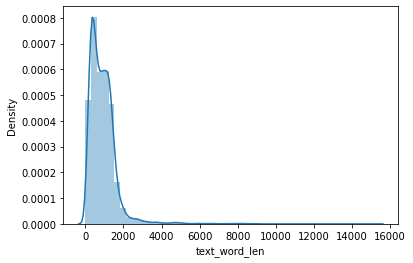

In [275]:
sns.distplot(reliable_data['text_word_len'])

<AxesSubplot:xlabel='text_word_len', ylabel='Density'>

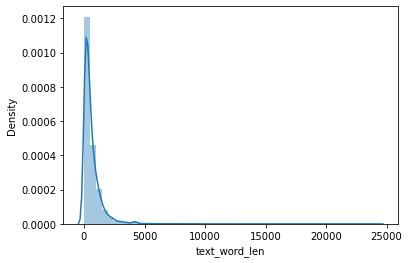

In [276]:
sns.distplot(non_reliable_data['text_word_len'])

<h2>Observation</h2>

<p>It can be seen that in reliable bews the text or the body has fewer words when compared to the non reliable news</p>


In [277]:
for i in [0,25,50,75]:
    print("the ",i," th percentile value is ",np.percentile(reliable_data['text_word_len'],i))
    
print("*"*10)

print("the 95th  percentile value is ",np.round(np.percentile(reliable_data['text_word_len'],95),2))

print("*"*10)

i = 99.0
incr = 0.1
while i< 100:
    print("the ",i," th percentile value is ",np.round(np.percentile(reliable_data['text_word_len'],i),2))
    i+=incr
    i = np.round(i,2)

the  0  th percentile value is  1.0
the  25  th percentile value is  417.0
the  50  th percentile value is  798.0
the  75  th percentile value is  1215.0
**********
the 95th  percentile value is  1868.7
**********
the  99.0  th percentile value is  3775.42
the  99.1  th percentile value is  4069.1
the  99.2  th percentile value is  4355.89
the  99.3  th percentile value is  4648.28
the  99.4  th percentile value is  4786.04
the  99.5  th percentile value is  5000.21
the  99.6  th percentile value is  5417.17
the  99.7  th percentile value is  6197.82
the  99.8  th percentile value is  6903.79
the  99.9  th percentile value is  8168.3


In [278]:
for i in [0,25,50,75]:
    print("the ",i," th percentile value is ",np.percentile(non_reliable_data['text_word_len'],i))
    
print("*"*10)

print("the 95th  percentile value is ",np.round(np.percentile(non_reliable_data['text_word_len'],95),2))

print("*"*10)

i = 99.0
incr = 0.1
while i< 100:
    print("the ",i," th percentile value is ",np.round(np.percentile(non_reliable_data['text_word_len'],i),2))
    i+=incr
    i = np.round(i,2)

the  0  th percentile value is  1.0
the  25  th percentile value is  173.0
the  50  th percentile value is  382.0
the  75  th percentile value is  790.0
**********
the 95th  percentile value is  1966.4
**********
the  99.0  th percentile value is  4150.0
the  99.1  th percentile value is  4211.46
the  99.2  th percentile value is  4276.34
the  99.3  th percentile value is  4307.46
the  99.4  th percentile value is  4506.17
the  99.5  th percentile value is  5052.94
the  99.6  th percentile value is  5709.92
the  99.7  th percentile value is  6760.68
the  99.8  th percentile value is  8231.67
the  99.9  th percentile value is  11657.0


In [279]:
reliable_auth = set(reliable_data['author'].unique())
non_reliable_auth = set(non_reliable_data['author'].unique())

common_auth = reliable_auth.intersection(non_reliable_auth)
print("number of common authors between relaible and non reliable set ",len(common_auth))

number of common authors between relaible and non reliable set  7


In [280]:
train_data[train_data['author'].isin(common_auth)]['author'].unique()

array(['noauthor', 'pamkey', 'davidesanger', 'pamelageller', 'anncoulter',
       'afp', 'reuters'], dtype=object)

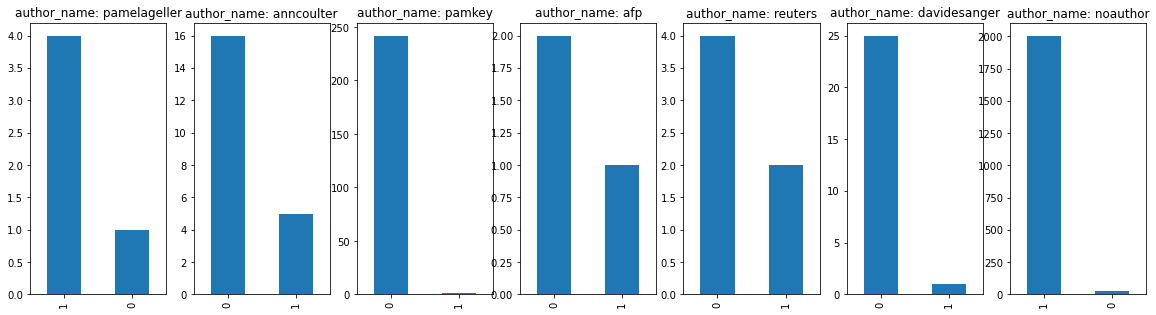

In [281]:
cnt  = 1
plt.figure(figsize=(20,5))
for i in common_auth:
    
    plt.subplot(1,len(common_auth),cnt)
    plt.title(f'author_name: {i}')

    train_data[train_data['author'] == i]['label'].value_counts().plot(kind='bar')
    cnt+=1

<h3>Observation </h3>

1. From the above we can say that when author name is NA or blank majority of the articles are non reliable.

2. From individual contributors like pam geller,ann coulter,pam key and david sanegar we find that the number of relaible 
   text are much higher than the number of unrelaible ones.
   
3. Text from news agencies like AFP and Reuters the number of relaible and non reliables articles are almost equal.

In [282]:
reliable_data.sort_values('author_article_count',ascending=False)['author'].unique()[0:10]

array(['noauthor', 'pamkey', 'jeromehudson', 'charliespiering',
       'johnhayward', 'katherinerodriguez', 'warnertoddhuston',
       'ianhanchett', 'breitbartnews', 'danielnussbaum'], dtype=object)

In [283]:
non_reliable_data.sort_values('author_article_count',ascending=False)['author'].unique()[0:10]

array(['noauthor', 'pamkey', 'admin', 'pakalert', 'eddylavine',
       'starkman', 'alexansary', 'gillian', 'editor', 'activistpost'],
      dtype=object)

In [284]:
train_data.head()

,id,title,author,text,label,title_processed,author_article_count,text_word_len
0,0,house dem aide: we didn’t even see comey’s let...,darrelllucus,house dem aide: we didn’t even see comey’s let...,1,hous dem aid we did not even see comey is lett...,10.0,820
1,1,"flynn: hillary clinton, big woman on campus - ...",danieljflynn,ever get the feeling your life circles the rou...,0,flynn hillari clinton big woman on campu breit...,17.0,727
2,2,why the truth might get you fired,consortiumnewscom,"why the truth might get you fired october 29, ...",1,whi the truth might get you fire,58.0,1266
3,3,15 civilians killed in single us airstrike hav...,jessicapurkiss,videos 15 civilians killed in single us airstr...,1,15 civilian kill in singl us airstrik have bee...,1.0,559
4,4,iranian woman jailed for fictional unpublished...,howardportnoy,print \nan iranian woman has been sentenced to...,1,iranian woman jail for fiction unpublish stori...,44.0,154


In [285]:
train_data.drop(['title'],axis=1,inplace=True)

In [286]:
X = train_data.drop('label',axis=1)
y = train_data['label']

X_tr,X_cv,y_tr,y_cv = train_test_split(X,y,test_size = 0.2,stratify = y)

In [310]:
stopwords_list = requests.get("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").content
stopwords = set(stopwords_list.decode().splitlines()) 
tfidf_vec = TfidfVectorizer(min_df=5,max_features=5000,stop_words=stopwords)
tfidf_vec.fit(X_tr['title_processed'])
X_tr_dtm = tfidf_vec.transform(X_tr['title_processed'])
X_cv_dtm = tfidf_vec.transform(X_cv['title_processed'])

count_vect = CountVectorizer(binary = True)
count_vect.fit(X_tr['author'])
X_tr_author = count_vect.transform(X_tr['author'])
X_cv_author = count_vect.transform(X_cv['author'])



X_tr_data = hstack([X_tr_dtm,X_tr_author,np.array(X_tr['author_article_count']).reshape(-1,1),np.array(X_tr['text_word_len']).reshape(-1,1)]).tocsr()
X_cv_data = hstack([X_cv_dtm,X_cv_author,np.array(X_cv['author_article_count']).reshape(-1,1),np.array(X_cv['text_word_len']).reshape(-1,1)]).tocsr()

In [321]:
np.argmax(X_tr_author.toarray()[0])

804

Text(0, 0.5, 'Accuracy')

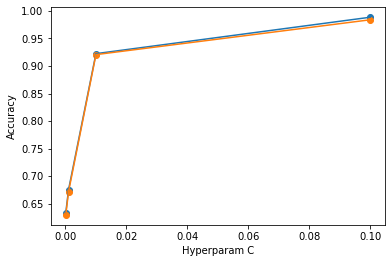

In [328]:
C = [0.0001,0.001,0.01,0.1]
train_acc = []
cv_acc = []

for i in C:
    lr = LogisticRegression(C  = i)
    lr.fit(X_tr_data,y_tr)
    y_pred = lr.predict(X_tr_data)
    y_pred_cv = lr.predict(X_cv_data)
    from sklearn.metrics import accuracy_score

    train_acc.append(accuracy_score(y_tr,y_pred))
    cv_acc.append(accuracy_score(y_cv,y_pred_cv))
    
plt.plot(C,train_acc)
plt.scatter(C,train_acc)
plt.plot(C,cv_acc)
plt.scatter(C,cv_acc)
plt.xlabel("Hyperparam C")
plt.ylabel("Accuracy")


<h3>Test data pipeline </h3>

In [335]:
test_data = pd.read_csv("test.csv")
submit_data = pd.read_csv("submit.csv")

test_data =  pd.merge(test_data,submit_data,on='id')


In [336]:
title_cleaned_te = []
test_data['title'] = test_data['title'].astype("str")
for title in test_data['title'].values:
#     print(type(title))
    title_clean = decontracted(title)
    title_cleaned_te.append(title_clean)


title_cleaned_te_sp = []

for title in title_cleaned_te:
    title_clean = remove_special_char(title)
    title_cleaned_te_sp.append(title_clean)




title_cleaned_te_sm = []

for title in title_cleaned_te_sp:
    title_clean = stemming(title)
    title_cleaned_te_sm.append(title_clean)



if test_data[test_data['author'].isna()].shape != 0:
    test_data['author'].fillna(value='no author',inplace=True)
test_data['author'] = test_data['author'].astype("str")
test_data['author'] = test_data['author'].str.lower()

author_cleaned_te_sp = []
for auth in test_data['author']:
    author_clean = remove_special_char(auth)
    author_clean = author_clean.split(' ')
    author_clean = ''.join(author_clean)
    author_cleaned_te_sp.append(author_clean)

test_data['author'] = author_cleaned_te_sp


author_count_te = test_data.loc[:,['author','label']].groupby("author").count()
author_count_te.columns = ['article_count']

author_count_te.reset_index(inplace=True)

test_data["author_article_count"] = np.nan
for index,rows in tqdm(test_data.iterrows()):
    author_name = rows['author']
    
    if author_count_te[author_count_te['author'] == author_name]['article_count'].values.shape[0] != 0:
        count = author_count_te[author_count_te['author'] == author_name]['article_count'].values[0]
        
    else :
        count = 0
        
    
    test_data.loc[index,"author_article_count"] = count




text_len = []

test_data['text'] = test_data.text.astype("str")
for text in test_data['text'].values:
    text_data = text
    text_list = text_data.split(' ')
    num_words = len(text_list)
    text_len.append(num_words)
    
	
test_data['text_word_len'] = text_len
test_data['title_processed'] = title_cleaned_te_sm


['Specter', 'of', 'Trump', 'Loosens', 'Tongues', 'if', 'Not', 'Purse', 'Strings', 'in', 'Silicon', 'Valley', 'The', 'New', 'York', 'Times']
['Russian', 'warships', 'ready', 'to', 'strike', 'terrorists', 'near', 'Aleppo']
['NoDAPL', 'Native', 'American', 'Leaders', 'Vow', 'to', 'Stay', 'All', 'Winter', 'File', 'Lawsuit', 'Against', 'Police']
['Tim', 'Tebow', 'Will', 'Attempt', 'Another', 'Comeback', 'This', 'Time', 'in', 'Baseball', 'The', 'New', 'York', 'Times']
['Keiser', 'Report', 'Meme', 'Wars', 'E995']
['Trump', 'is', 'USA', 'is', 'antique', 'hero', 'Clinton', 'will', 'be', 'next', 'president']
['Pelosi', 'Calls', 'for', 'FBI', 'Investigation', 'to', 'Find', 'Out', 'What', 'the', 'Russians', 'Have', 'on', 'Donald', 'Trump', 'Breitbart']
['Weekly', 'Featured', 'Profile', 'Randy', 'Shannon']
['Urban', 'Population', 'Booms', 'Will', 'Make', 'Climate', 'Change', 'Worse']
['nan']
['184', 'U', 'S', 'generals', 'and', 'admirals', 'endorse', 'Trump', 'for', 'Commander', 'In', 'Chief']
['Wo

['Global', 'Unrest', 'Cycle', 'Elects', 'Evangelical', 'Mayor', 'for', 'Rio']
['The', 'Modern', 'History', 'of', 'Rigged', 'US', 'Elections']
['Celebrities', 'Defend', 'Stephen', 'Colbert', 'is', 'C', 'ck', 'Holster', 'Joke']
['Last', 'Stand', 'for', 'ISIS']
['Friday', 'Mailbag', 'Christian', 'Values', 'the', 'Jewish', 'Sabbath', 'and', 'BuzzFeed', 'The', 'New', 'York', 'Times']
['The', 'people', 'voted', 'for', 'a', 'military', 'coup', 'says', 'Theresa', 'May']
['Questioning', 'Gender', 'Amid', 'a', 'Chaotic', 'East', 'Village', 'Childhood', 'The', 'New', 'York', 'Times']
['26', 'Billion', 'Dollars', 'for', 'the', 'Jewish', 'Lobby', 'Just', 'the', 'Tip', 'of', 'the', 'Iceberg']
['Hannity', 'FBI', 'Knows', 'They', 'Are', 'About', 'to', 'Be', 'Exposed', 'By', 'WikiLeaks', 'EndingFed', 'News', 'Network']
['How', 'World', 'War', 'III', 'Could', 'Start']
['Wikileaks', 'Julian', 'Assange', 'at', 'Embassy', 'Balcony', 'I', 'Will', 'Not', 'Forgive', 'And', 'Forget', 'Criticises', 'CIA', 'and'

['The', 'Geopolitics', 'of', 'Russia', 'Egypt', 'Relations']
['Puberty', 'Before', 'Age', '10', 'A', 'New', 'Normal']
['US', 'Korean', 'Relations', 'and', 'the', 'New', 'US', 'President', 'New', 'Eastern', 'Outlook']
['Elena', 'Ferrante', 'is', 'Picture', 'Book', 'Embraces', 'the', 'Dark', 'Side', 'The', 'New', 'York', 'Times']
['Stress', 'Over', 'Family', 'Finances', 'Propelled', 'Hillary', 'Clinton', 'Into', 'Corporate', 'World', 'The', 'New', 'York', 'Times']
['The', 'Met', 'Opera', 'is', 'Rusalka', 'Is', 'a', 'Dark', 'Sexy', 'Hit', 'The', 'New', 'York', 'Times']
['Trump', 'Vows', 'To', 'Renovate', 'the', 'Bill', 'of', 'Rights']
['Trump', 'is', 'Walk', 'of', 'Fame', 'star', 'smashed', 'with', 'a', 'sledgehammer', 'VIDEO']
['Susan', 'Rice', 'Donald', 'Trump', 'Stone', 'Cold', 'Crazy', 'for', 'Appointing', 'Steve', 'Bannon', 'to', 'NSC', 'Breitbart']
['YOUR', 'SUSPICIONS', 'ABOUT', 'GMO', 'CROPS', 'WERE', 'JUST', 'CONFIRMED', 'BY', 'A', 'NYT', 'REPORT']
['It', 'Just', 'Got', 'WAY', 'B

['Channel', '4', 'announces', 'neverending', 'cycle', 'of', 'Gogglebox', 'spinoffs']
['Dozens', 'of', 'Inmates', 'Killed', 'as', 'Prison', 'Violence', 'Escalates', 'in', 'Brazil', 'The', 'New', 'York', 'Times']
['Aleksei', 'Navalny', 'Viable', 'Putin', 'Rival', 'Is', 'Barred', 'From', 'a', 'Presidential', 'Run', 'The', 'New', 'York', 'Times']
['What', 'is', 'Next', 'for', 'the', 'New', 'York', 'Subway', 'Toronto', 'Already', 'Knows', 'The', 'New', 'York', 'Times']
['Robert', 'Barnes', 'Hawaii', 'Obama', 'Judge', 'Rules', 'Muslim', 'Imam', 'Has', 'Special', 'Constitutional', 'Rights', 'to', 'Bring', 'Anyone', 'from', 'Terror', 'Countries', 'into', 'America']
['BREAKING', 'Racketeering', 'indictment', 'of', 'Hillary', 'Clinton', 'now', 'likely', 'as', 'FOIA', 'for', 'Datto', 'backup', 'device', 'reveals', 'FBI', 'possesses', 'ALL', 'the', 'incriminating', 'emails']
['Norway', 'and', 'China', 'Restore', 'Ties', '6', 'Years', 'After', 'Nobel', 'Prize', 'Dispute', 'The', 'New', 'York', 'Tim

['Lena', 'Dunham', 'Posts', 'Video', 'Celebrating', 'the', 'Extinction', 'of', 'White', 'Men', 'on', 'Twitter']
['Reading', 'the', 'Classic', 'Novel', 'That', 'Predicted', 'Trump', 'The', 'New', 'York', 'Times']
['Like', 'a', 'Concentration', 'Camp', 'Police', 'Mark', 'DAPL', 'Protesters', 'with', 'Numbers', 'and', 'Lock', 'Them', 'in', 'Dog', 'Kennels']
['Swiss', 'volunteer', 'firefighters', 'It', 'is', 'ok', 'to', 'be', 'a', 'bit', 'tipsy', 'when', 'reporting', 'for', 'duty']
['Report', 'How', 'to', 'Listen', 'to', 'and', 'Delete', 'Every', 'Voice', 'Recording', 'Saved', 'by', 'Amazon', 'Echo', 'Breitbart']
['Arianna', 'Huffington', 'journalist', 'echo', 'chamber', 'for', 'Hillary', 'Clinton']
['Gender', 'Bending', 'Berkeley', 'Murder', 'Suspect', 'Wants', 'to', 'be', 'Referred', 'to', 'as', 'They', 'Breitbart']
['Donald', 'Trump', 'Vows', 'Court', 'Battle', 'for', 'Common', 'Sense', 'Immigration', 'Executive', 'Order']
['Susan', 'Sarandon', 'I', 'Do', 'not', 'Think', 'Trump', 'is', 

['Ra', 'Ra', 'Rasputin', 'Russia', 'is', 'famous', 'love', 'machine', 'gets', 'new', 'biography', 'this', 'fall']
['A', 'Small', 'Town', 'Resident', 'is', 'Secret', 'for', '48', 'Years', 'He', 'Was', 'a', 'Fugitive', 'The', 'New', 'York', 'Times']
['Report', 'More', 'Americans', 'Between', '18', 'and', '34', 'Live', 'with', 'Parents', 'Than', 'Spouse', 'Breitbart']
['Clinton', 'Campaign', 'Planned', 'To', 'Vilify', 'Nurses', 'For', 'Backing', 'Sanders']
['Umfrage', 'CETA', 'w', 'rde', 'enorm', 'an', 'Zustimmung', 'gewinnen', 'wenn', 'EU', 'kanadische', 'Cannabis', 'Standards', 'bernehmen', 'm', 'sste']
['With', 'an', 'Arsenal', 'of', 'Apps', 'a', 'Fearful', 'Flier', 'Faces', 'the', 'Skies', 'The', 'New', 'York', 'Times']
['Leslie', 'Jones', 'on', 'MILO', 'Book', 'Deal', 'Simon', 'amp', 'Schuster', 'Helping', 'Spread', 'Hate', 'Breitbart']
['Cressida', 'Dick', 'Will', 'Be', 'First', 'Woman', 'to', 'Lead', 'Scotland', 'Yard', 'The', 'New', 'York', 'Times']
['Look', 'at', 'the', 'SHOCKING

['North', 'Dakota', 'Pipeline', 'Cell', 'Service', 'Blacked', 'Out', 'As', 'Violence', 'Against', 'Protesters', 'Increases']
['New', 'Solar', 'Panels', 'Pull', 'Drinking', 'Water', 'From', 'The', 'Air', 'Because', 'Clean', 'Water', 'Is', 'A', 'Human', 'Right']
['The', 'Battle', 'of', 'Miss', 'Saigon', 'Yellowface', 'Art', 'and', 'Opportunity', 'The', 'New', 'York', 'Times']
['For', 'Washington', 'Destroying', 'Syria', 'is', 'a', 'Bipartisan', 'Agenda', 'Tony', 'Cartalucci']
['Florida', 'Man', 'Strangled', 'Wife', 'Then', 'Impersonated', 'Her', 'on', 'Facebook', 'Police', 'Say', 'The', 'New', 'York', 'Times']
['Lindsey', 'Graham', 'Democrats', 'Cleaned', 'Our', 'Clock', 'on', 'Spending', 'Bill', 'Breitbart']
['Here', 'is', 'how', 'against', 'the', 'Republican', 'Establishment', 'Trump', 'is']
['With', 'Audience', 'Shrinking', 'NBC', 'Looks', 'Cautiously', 'to', 'Olympics', 'in', 'Asia', 'The', 'New', 'York', 'Times']
['Those', 'With', 'Multiple', 'Tours', 'of', 'War', 'Overseas', 'Strug

['nan']
['Rachel', 'Maddow', 'And', 'The', 'RNC', 'is', 'Preemptive', 'Surrender', 'On', 'Voter', 'Fraud']
['Wikileaks', 'May', 'Release', 'Hillary', 'is', '33', '000', 'Deleted', 'Emails', 'Kim', 'Dotcom']
['Re', 'DEVELOPING', 'Mike', 'Pence', 'is', 'plane', 'skids', 'off', 'wet', 'runway', 'at', 'LaGuardia', 'Airport', 'in', 'NYC']
['Kurdish', 'Politician', 'Who', 'Vanished', 'in', 'Turkey', 'Turns', 'Up', 'in', 'Iraq', 'The', 'New', 'York', 'Times']
['U', 'S', 'Arming', 'Syrian', 'Rebels', 'amid', 'Looming', 'Threat', 'from', 'Iran', 'Allied', 'Militias']
['17', 'Year', 'Old', 'Indigo', 'Child', 'Message', 'to', 'the', 'New', 'Children', 'and', 'Lightworkers']
['Twitter', 'Appoints', 'Debra', 'Lee', 'Adding', 'Diversity', 'to', 'Its', 'Board', 'The', 'New', 'York', 'Times']
['KANSAS', 'Republican', 'Mailer', 'asks', 'voters', 'Have', 'you', 'met', 'the', 'new', 'neighbors', 'your', 'Muslim', 'terrorist', 'neighbors']
['Media', 'Hysteria', 'WaPo', 'Treats', 'Kevin', 'McCarthy', 'Joke

['Trump', 'Packs', 'His', 'Blunt', 'Phrase', 'Book', 'Abroad', 'The', 'New', 'York', 'Times']
['Former', 'Assistant', 'FBI', 'Director', 'Says', 'Clintons', 'Are', 'A', 'Crime', 'Family']
['Townhall', 'Why', 'the', 'MSM', 'Is', 'Ignoring', 'Trump', 'is', 'Sex', 'Trafficking', 'Busts', 'Breitbart']
['Whoa', 'Even', 'DEMOCRATS', 'Are', 'Now', 'Asking', 'What', 'is', 'The', 'Difference', 'Between', 'Bill', 'Clinton', 'And', 'Bill', 'Cosby']
['Nanny', 'In', 'Jail', 'After', 'Force', 'Feeding', 'Baby', 'To', 'Death']
['Biblical', 'Beginnings']
['nan']
['nan']
['Bruce', 'Arena', 'Replacing', 'Jurgen', 'Klinsmann', 'as', 'U', 'S', 'Coach', 'Keeps', 'Things', 'Simple', 'The', 'New', 'York', 'Times']
['Dallas', 'Police', 'Are', 'Used', 'to', 'Recovering', 'From', 'Being', 'in', 'Harm', 'is', 'Way', 'The', 'New', 'York', 'Times']
['Obamacare', 'Premiums', 'Spike', 'an', 'Average', 'of', '25']
['Is', 'the', 'Met', 'Museum', 'a', 'Great', 'Institution', 'in', 'Decline', 'The', 'New', 'York', 'Time

0it [00:00, ?it/s]

['Here', 'Are', 'Our', 'Stories', 'That', 'Won', 'the', 'Biggest', 'Awards', 'in', 'the', 'Magazine', 'World', 'The', 'New', 'York', 'Times']
['Comment', 'on', '6', 'Places', 'Voter', 'Fraud', 'Has', 'Already', 'Happened', 'But', 'Do', 'not', 'Worry', 'by', 'lenore', 'lee']
['Alan', 'Dershowtiz', 'Report', 'He', 'Will', 'Help', 'Defense', 'in', 'Female', 'Genital', 'Mutilation', 'Case', 'Fake', 'News', 'by', 'New', 'York', 'Times']
['Privacy', 'Group', 'Sues', 'NYPD', 'over', 'Freedom', 'of', 'Information', 'Request', 'on', 'Facial', 'Recognition', 'Program', 'Breitbart']
['IS', 'Jihadist', 'on', 'Eilat', 'Attack', 'The', 'Jewish', 'Enemy', 'Should', 'Anticipate', 'More']
['An', 'Identity', 'Politicized', 'Election', 'and', 'World', 'Series', 'Lakefront', 'Liberals', 'Can', 'Love']
['Evergreen', 'State', 'College', 'Protester', 'Arrested', 'on', 'Main', 'Campus', 'Plaza', 'Breitbart']
['Deutsche', 'Bank', 'LIVES', 'Shock', 'profits', 'posted', 'in', 'Q3']
['Moronic', 'Trump', 'Campaign

5200it [00:07, 709.43it/s]


In [337]:
test_data

,id,title,author,text,label,author_article_count,text_word_len,title_processed
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",davidstreitfeld,"PALO ALTO, Calif. — After years of scorning...",0,2.0,1387,specter of trump loosen tongu if not purs stri...
1,20801,Russian warships ready to strike terrorists ne...,noauthor,Russian warships ready to strike terrorists ne...,1,513.0,244,russian warship readi to strike terrorist near...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,commondreams,Videos #NoDAPL: Native American Leaders Vow to...,0,1.0,705,nodapl nativ american leader vow to stay all w...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",danielvictor,"If at first you don’t succeed, try a different...",1,11.0,668,tim tebow will attempt anoth comeback thi time...
4,20804,Keiser Report: Meme Wars (E995),truthbroadcastnetwork,42 mins ago 1 Views 0 Comments 0 Likes 'For th...,1,4.0,101,keiser report meme war e995
...,...,...,...,...,...,...,...,...
5195,25995,The Bangladeshi Traffic Jam That Never Ends - ...,jodyrosen,Of all the dysfunctions that plague the world’...,0,1.0,3204,the bangladeshi traffic jam that never end the...
5196,25996,John Kasich Signs One Abortion Bill in Ohio bu...,sherylgaystolberg,WASHINGTON — Gov. John Kasich of Ohio on Tu...,1,1.0,619,john kasich sign one abort bill in ohio but ve...
5197,25997,"California Today: What, Exactly, Is in Your Su...",mikemcphate,Good morning. (Want to get California Today by...,0,15.0,982,california today what exactli Is in your sushi...
5198,25998,300 US Marines To Be Deployed To Russian Borde...,noauthor,« Previous - Next » 300 US Marines To Be Deplo...,1,513.0,463,300 US marin To Be deploy To russian border In...


In [338]:
test_data.columns

Index(['id', 'title', 'author', 'text', 'label', 'author_article_count',
       'text_word_len', 'title_processed'],
      dtype='object')

In [339]:
X_test = test_data.drop('label',axis=1)
y_test = test_data['label']


In [341]:

X_test_dtm = tfidf_vec.transform(X_test['title_processed'])
X_test_author = count_vect.transform(X_test['author'])
X_test_data = hstack([X_test_dtm,X_test_author,np.array(X_test['author_article_count']).reshape(-1,1),np.array(X_test['text_word_len']).reshape(-1,1)]).tocsr()


In [ ]:
C = [0.0001,0.001,0.01,0.1]
test_acc = []


for i in C:
    
    y_pred = lr.predict(X_tr_data)
    
    from sklearn.metrics import accuracy_score

    train_acc.append(accuracy_score(y_tr,y_pred))
    cv_acc.append(accuracy_score(y_cv,y_pred_cv))
    
plt.plot(C,train_acc)
plt.scatter(C,train_acc)
plt.plot(C,cv_acc)
plt.scatter(C,cv_acc)
plt.xlabel("Hyperparam C")
plt.ylabel("Accuracy")


In [342]:
y_pred_test = lr.predict(X_test_data)


In [344]:
accuracy_score(y_test,y_pred_test)

0.6386538461538461